<span style="color:red;"> * ** TODO: ** * </span>
* Plot the weekly-hour for activity in addition to audio.
* granger causality & croscorrelation


## 0  Prepare

### 0.1 import packages

In [1]:
# package general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import os
import re
import pprint
import inspect

In [2]:
# Filter all warnings.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# clean dataset
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, make_scorer, precision_score
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA

# skelarn  random forest
from sklearn.naive_bayes import MultinomialNB,GaussianNB 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# sklearn naive bayes
from sklearn.preprocessing import StandardScaler

In [4]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [17]:
sensing_data_path = '../dataset/sensing'
education_path ='../dataset/education/'

audio_path = sensing_data_path + '/audio/'
activity_path = sensing_data_path + '/activity/'
conversation_path = sensing_data_path + '/conversation/'
dark_path='/dark/'

Data_path = '../Data/'
result_path = '../results/'

### 0.2 Global variable

In [6]:
CLUSTER_USER = [(0, 0), (1, 0), (2, 2), (3, 2), (4, 0), (5, 0), (6, 1), (7, 2), (8, 2), (9, 0), (10, 2), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 2), (17, 2), (18, 2), (19, 0), (20, 2), (21, 0), (22, 0), (23, 2), (24, 1), (25, 1), (26, 0), (27, 0), (28, 1), (29, 2), (30, 0), (31, 2), (32, 2), (33, 2), (34, 0), (35, 0), (36, 2), (37, 2), (38, 1), (39, 1)]
USER_ID2CLUSER = {'u00': 0, 
                  'u01': 0, 
                  'u02': 2, 
                  'u03': 2, 
                  'u04': 0,
 'u05': 0,
 'u07': 1,
 'u09': 2,
 'u10': 2,
 'u14': 0,
 'u15': 2,
 'u16': 1,
 'u17': 1,
 'u18': 2,
 'u19': 2,
 'u20': 1,
 'u23': 2,
 'u24': 2,
 'u27': 2,
 'u30': 0,
 'u31': 2,
 'u32': 0,
 'u33': 0,
 'u34': 2,
 'u35': 1,
 'u36': 1,
 'u42': 0,
 'u43': 0,
 'u44': 1,
 'u45': 2,
 'u46': 1,
 'u47': 0,
 'u49': 2,
 'u51': 2,
 'u52': 2,
 'u53': 0,
 'u54': 1,
 'u56': 0,
 'u58': 2,
 'u59': 2}
summary = pd.read_csv(Data_path+'summary_data.csv')
CLUSTER_ID2USER_ID = {}
for i,each in summary.iterrows():
    CLUSTER_ID2USER_ID[i] = each['uid'].strip('u')

In [174]:
# CLUSTER_ID2USER_ID

### 0.3 data cleaning functions

In [82]:

u01_conv.head()

,start_timestamp,end_timestamp
0,1364358643,1364359056
1,1364388374,1364391419
2,1364391630,1364392296
3,1364393248,1364393510
4,1364393720,1364395687


In [120]:

def custom_resampler(array_like):
    if len(array_like)>0:
        print(np.sum(array_like)/len(array_like))
        return np.sum(array_like)/len(array_like)
    else:
        return pd.to_timedelta('0 days')

# test time_range_create_df
u01_conv = pd.read_csv(conversation_path+'conversation_u01.csv')
u01_conv.columns = ['start_timestamp','end_timestamp']
df_user = convert_date(u01_conv,['start_timestamp','end_timestamp'],True)
df_user.index = df_user['start_timestamp']

df_user['duration'] = pd.to_timedelta(df_user['end_timestamp'] - df_user['start_timestamp'])
# print('ei',df_user['duration'].mean(),df_user.index)

# get total times of coversation
cov_freq = df_user['duration'].resample('D').apply(custom_resampler)
df_user[(df_user.index.day==2) & (df_user.index.month==5)]['duration'],cov_freq

0 days 00:20:10.666666
0 days 00:08:09.044444
0 days 00:15:29.394736
0 days 00:19:16.416666
0 days 00:08:26.191489
0 days 00:12:15.390243
0 days 00:06:04.441176
0 days 00:35:49.545454
0 days 00:15:38.600000
0 days 00:14:39.600000
0 days 00:14:20.027027
0 days 00:18:09.896551
0 days 00:11:41
0 days 00:13:47.848484
0 days 00:19:37.052631
0 days 00:12:37.176470
0 days 00:20:34.050000
0 days 00:17:04.035714
0 days 00:12:10.852941
0 days 00:10:17.411764
0 days 00:10:33.545454
0 days 00:15:26.319148
0 days 00:12:37.904761
0 days 00:13:01.446808
0 days 00:10:55.103448
0 days 00:06:17.880597
0 days 00:11:15.263157
0 days 00:17:13.071428
0 days 00:11:50.027027
0 days 00:09:52.041095
0 days 00:08:37.181818
0 days 00:07:42.564102
0 days 00:16:45.269230
0 days 00:25:57
0 days 00:11:28.245614
0 days 00:05:08.200000
0 days 00:19:43.916666
0 days 00:16:34.729729
0 days 00:11:18.092307
0 days 00:10:55.490566
0 days 00:10:23.500000
0 days 00:14:21.227272
0 days 00:14:19.763157
0 days 00:20:12.766666
0 

(start_timestamp
 2013-05-02 17:00:23-04:00   00:18:50
 2013-05-02 17:23:03-04:00   00:16:09
 2013-05-02 21:03:35-04:00   00:02:31
 2013-05-02 21:10:37-04:00   01:49:25
 2013-05-02 23:03:53-04:00   00:13:37
 2013-05-02 23:17:40-04:00   00:01:11
 2013-05-02 23:26:52-04:00   00:23:42
 2013-05-02 23:54:55-04:00   00:22:11
 Name: duration, dtype: timedelta64[ns], start_timestamp
 2013-03-27 00:00:00-04:00   00:20:10.666666
 2013-03-28 00:00:00-04:00   00:08:09.044444
 2013-03-29 00:00:00-04:00   00:15:29.394736
 2013-03-30 00:00:00-04:00   00:19:16.416666
 2013-03-31 00:00:00-04:00   00:08:26.191489
 2013-04-01 00:00:00-04:00   00:12:15.390243
 2013-04-02 00:00:00-04:00   00:06:04.441176
 2013-04-03 00:00:00-04:00   00:35:49.545454
 2013-04-04 00:00:00-04:00   00:15:38.600000
 2013-04-05 00:00:00-04:00   00:14:39.600000
 2013-04-06 00:00:00-04:00   00:14:20.027027
 2013-04-07 00:00:00-04:00   00:18:09.896551
 2013-04-08 00:00:00-04:00          00:11:41
 2013-04-09 00:00:00-04:00   00:13:47

In [69]:
def get_fname(path):
    # get file name for all subfiles for the whole ukwac corpus.
    file = [f for f in os.listdir(path) if re.search('(.+\.csv$)', f)]
    file = sorted(file)
    return file

In [210]:
def convert_date(df, columns=['timestamp'],time_range = False):
    
    """ # input: 
        df: original dataframe. 
        columns: represent names of columns that was time type.
        change_index: True for audio and activity data, False for conversation data
        # output: dataframe. Turn timestamp from unix time into readable time. and set index and change time zone.
    """
    for col in columns:
        df[col] = pd.to_datetime(df[col],unit='s',utc=True).dt.tz_convert('US/Eastern') # .dt.tz_localize('US/Eastern')
        if not time_range:
            #there is only on timestamp column, so use it as index
            df.index =  pd.to_datetime(df[col]) # .dt.date
    return df

In [195]:
def custom_resampler(array_like):
    if len(array_like)>0:

        return np.sum(array_like)/len(array_like)
    else:
        return pd.to_timedelta('0 days')
    
def time_range_create_df(path,unit = 'H',time_range = False, agg_method = 'mean'):
    """
    # input:
    path: path of directory of all files.
    unit: whether H for hourly or D for Daily
    change_index: True for audio and activity data, False for conversation data
    """
    f_names = get_fname(path)
    new_time_df = pd.DataFrame()

    for user_f in f_names:

        data_user = pd.read_csv(path+user_f)
        
        # new for range data
        if time_range:
            
            data_user.columns = ['start_timestamp','end_timestamp']
            df_user = convert_date(data_user,['start_timestamp','end_timestamp'],time_range)
            df_user.index = df_user['start_timestamp']
            
            if str(agg_method) == 'mean':
                df_user['duration'] = pd.to_timedelta(df_user['end_timestamp'] - df_user['start_timestamp'])
                

                # get total times of coversation
                cov_freq = df_user['duration'].resample(unit).apply(custom_resampler)
                
                # turn a series of data into a row(with dataframe type).
                cov_freq_transposed = cov_freq.to_frame(name=re.sub(r'^conversation_(.+)\.csv$', '\g<1>', user_f)).transpose()
            
            elif str(agg_method) == 'max':
                df_user['duration'] = pd.to_timedelta(df_user['end_timestamp'] - df_user['start_timestamp'])
                

                # get total times of coversation
                cov_freq = df_user['duration'].resample(unit).max()
                
                # turn a series of data into a row(with dataframe type).
                cov_freq_transposed = cov_freq.to_frame(name=re.sub(r'^conversation_(.+)\.csv$', '\g<1>', user_f)).transpose()
 
            elif  str(agg_method) == 'count':
                # get total times of coversation
                cov_freq = df_user['start_timestamp'].resample(unit).count()
            
                # turn a series of data into a row(with dataframe type).
                cov_freq_transposed = cov_freq.to_frame(name=re.sub(r'^conversation_(.+)\.csv$', '\g<1>', user_f)).transpose()
            
            # add into final result
            new_time_df = pd.concat([new_time_df,cov_freq_transposed])
        else:

            df_user = convert_date(data_user)

            # select '*** inference' column name
            col_inf = [i for i in df_user.columns if 'inference' in i][0]

            if drop:
                # remove_unrecognized_category: '3: Unknown'
                df_user = df_user[(df_user[col_inf]!=3)]
        
            # group second data into days.
            weekly = df_user[col_inf].resample(unit).mean()
            # weekly.plot(style = [':','--','-'])


            # turn a series of data into a row(with dataframe type).
            weekly_transposed = weekly.to_frame(name=user_f.strip('.csv')).transpose()

            # add into final result
            new_time_df = pd.concat([new_time_df,weekly_transposed])
    return new_time_df
conversation_time_df_day_count = time_range_create_df(conversation_path,unit = 'D',time_range = True, agg_method='count')

conversation_time_df_day_mean = time_range_create_df(conversation_path,unit = 'D',time_range = True, agg_method='mean')


In [ ]:
conversation_time_df_day_mean = time_range_create_df(conversation_path,unit = 'D',time_range = True, agg_method='mean')

In [186]:
re.sub(r'^conversation_(.+)\.csv$', '\g<1>', 'conversation_u02.csv')

'u02'

In [197]:
conversation_time_df_day_count.transpose().head()

,u00,u01,u02,u03,u04,u05,u07,u08,u09,u10,...,u49,u50,u51,u52,u53,u54,u56,u57,u58,u59
start_timestamp,,,,,,,,,,,,,,,,,,,,,
2013-03-27 00:00:00-04:00,26.0,18.0,8.0,16.0,50.0,15.0,37.0,23.0,28.0,40.0,...,NaN,NaN,16.0,8.0,23.0,21.0,14.0,22.0,19.0,30.0
2013-03-28 00:00:00-04:00,29.0,45.0,9.0,6.0,39.0,34.0,24.0,30.0,41.0,52.0,...,12.0,31.0,34.0,37.0,17.0,31.0,18.0,26.0,37.0,31.0
2013-03-29 00:00:00-04:00,35.0,38.0,19.0,4.0,33.0,30.0,32.0,29.0,29.0,25.0,...,28.0,21.0,34.0,19.0,24.0,24.0,14.0,18.0,29.0,38.0
2013-03-30 00:00:00-04:00,18.0,24.0,29.0,1.0,42.0,25.0,20.0,27.0,30.0,17.0,...,21.0,16.0,37.0,29.0,35.0,36.0,29.0,20.0,27.0,35.0
2013-03-31 00:00:00-04:00,23.0,47.0,27.0,1.0,32.0,21.0,53.0,25.0,4.0,23.0,...,26.0,42.0,47.0,6.0,28.0,50.0,24.0,37.0,25.0,25.0


In [207]:
def get_analysis_before_after(df,split_date= '2013-05-01',duration = True):

    before_columns = [i for i in df.columns if pd.to_datetime(i).date() <= pd.to_datetime(split_date).date()]
    after_columns = [i for i in df.columns if pd.to_datetime(i).date() > pd.to_datetime(split_date).date()]

    before_df = df[before_columns]
    after_df = df[after_columns]

    before_series = before_df.transpose().mean().transpose()
    after_series = after_df.transpose().mean().transpose()
    
    if duration:
        before_series = before_series.dt.total_seconds()/60
        after_series = after_series.dt.total_seconds()/60

    return before_series, after_series


In [215]:
conversation_time_df_day_count = time_range_create_df(conversation_path,unit = 'D',time_range = True, agg_method='count')
conversation_time_df_day_mean = time_range_create_df(conversation_path,unit = 'D',time_range = True, agg_method='mean')

cov_count_before_series, cov_count_after_series = get_analysis_before_after(conversation_time_df_day_count, duration=False)
cov_mean_before_series, cov_mean_after_series = get_analysis_before_after(conversation_time_df_day_mean)


In [216]:
conversation_result = pd.concat([cov_count_before_series, cov_count_after_series,cov_mean_before_series, cov_mean_after_series],axis =1)
conversation_result.columns=['cov_count_before','cov_count_after','cov_mean_before','cov_mean_after']

In [217]:
conversation_result.index

Index(['u00', 'u01', 'u02', 'u03', 'u04', 'u05', 'u07', 'u08', 'u09', 'u10',
       'u12', 'u13', 'u14', 'u15', 'u16', 'u17', 'u18', 'u19', 'u20', 'u22',
       'u23', 'u24', 'u25', 'u27', 'u30', 'u31', 'u32', 'u33', 'u34', 'u35',
       'u36', 'u39', 'u41', 'u42', 'u43', 'u44', 'u45', 'u46', 'u47', 'u49',
       'u50', 'u51', 'u52', 'u53', 'u54', 'u56', 'u57', 'u58', 'u59'],
      dtype='object')

In [219]:
phone_all = pd.read_csv('/Users/G_bgyl/si671/stu_project/Data/final_report/phone_all.csv')
phone_all.index=phone_all['uid']
gps_all = pd.read_csv('/Users/G_bgyl/si671/stu_project/Data/final_report/gps_all.csv')
gps_all.index = gps_all['uid']

In [224]:
gps_all.head()

,uid,weekend_locvar,weekday_locvar,before_moving,after_moving
uid,,,,,
u00,u00,-1.734485,-2.162183,16.685714,15.961538
u01,u01,-2.302554,-2.302559,16.428571,23.181818
u02,u02,-2.286666,-2.300463,9.600000,21.115385
u03,u03,-2.302580,-2.302579,5.080000,3.500000
u04,u04,-2.302508,-2.302410,27.735294,24.666667


In [211]:
audio_time_df_day = create_time_df(audio_path,unit = 'D')
activity_time_df_day = create_time_df(activity_path,unit = 'D')


In [212]:
audio_time_df_day.head()

timestamp,2013-03-27 00:00:00-04:00,2013-03-28 00:00:00-04:00,2013-03-29 00:00:00-04:00,2013-03-30 00:00:00-04:00,2013-03-31 00:00:00-04:00,2013-04-01 00:00:00-04:00,2013-04-02 00:00:00-04:00,2013-04-03 00:00:00-04:00,2013-04-04 00:00:00-04:00,2013-04-05 00:00:00-04:00,...,2013-05-22 00:00:00-04:00,2013-05-23 00:00:00-04:00,2013-05-24 00:00:00-04:00,2013-05-25 00:00:00-04:00,2013-05-26 00:00:00-04:00,2013-05-27 00:00:00-04:00,2013-05-28 00:00:00-04:00,2013-05-29 00:00:00-04:00,2013-05-30 00:00:00-04:00,2013-05-31 00:00:00-04:00
audio_u00,0.716408,0.720428,0.909865,1.253173,0.841533,0.703263,1.009159,0.800291,0.674140,0.934161,...,0.938110,1.026862,1.149064,1.156300,0.287203,0.635571,0.774879,0.949070,0.971463,1.022147
audio_u01,0.734605,0.904873,0.907526,0.709102,0.672812,1.020760,0.608127,0.820153,0.816312,0.871042,...,0.000000,0.000000,0.000000,0.910607,0.988937,0.821036,0.670783,0.502685,NaN,NaN
audio_u02,0.237331,0.298262,0.725468,0.779516,0.846423,0.688239,0.710498,0.007589,0.732829,0.402746,...,0.334038,0.433622,0.912639,0.584197,0.415024,0.573744,0.493600,1.056425,0.631030,0.967426
audio_u03,0.383900,0.170643,0.377547,0.022307,0.018275,0.407861,0.009501,0.347968,0.023253,0.357316,...,0.019010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
audio_u04,0.988433,0.942655,1.053628,0.832146,1.044645,0.969813,0.731920,0.924820,0.961761,0.974308,...,0.709104,0.098234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [225]:
audio_before_series, audio_after_series = get_analysis_before_after(audio_time_df_day, duration=False)
activity_before_series, activity_after_series = get_analysis_before_after(activity_time_df_day, duration=False)
a_result = pd.concat([cov_count_before_series, cov_count_after_series,cov_mean_before_series, cov_mean_after_series],axis =1)
a_result.columns=['audio_before','audio_after','activity_before','activity_after']

whole_result = pd.concat([conversation_result,a_result,phone_all,gps_all],axis =1)
whole_result.drop(columns=['uid'])

,cov_count_before,cov_count_after,cov_mean_before,cov_mean_after,audio_before,audio_after,activity_before,activity_after,before_charge,after_charge,...,before_sleep,after_sleep,before_play_dark,after_play_dark,before_sleep_dark,after_sleep_dark,weekend_locvar,weekday_locvar,before_moving,after_moving
u00,32.277778,31.633333,14.137514,11.515206,32.277778,31.633333,14.137514,11.515206,6.907980,6.244295,...,5.169559,4.987853,14.464984,18.061865,5.196797,3.815734,-1.734485,-2.162183,16.685714,15.961538
u01,37.750000,29.285714,12.734380,10.220096,37.750000,29.285714,12.734380,10.220096,7.425152,7.372500,...,7.288725,6.595863,10.872682,13.181389,6.220295,5.339788,-2.302554,-2.302559,16.428571,23.181818
u02,23.722222,20.966667,14.371453,13.411877,23.722222,20.966667,14.371453,13.411877,7.585185,6.145208,...,5.126701,4.443825,13.683811,15.224252,7.037578,5.630929,-2.286666,-2.300463,9.600000,21.115385
u03,9.638889,6.550000,8.416439,4.214764,9.638889,6.550000,8.416439,4.214764,8.299505,7.817500,...,6.703492,4.945583,15.297417,15.292049,5.470597,6.023958,-2.302580,-2.302579,5.080000,3.500000
u04,46.138889,48.909091,9.828091,8.665249,46.138889,48.909091,9.828091,8.665249,7.659892,7.540278,...,7.226574,7.100355,9.478562,9.631930,6.877917,6.324225,-2.302508,-2.302410,27.735294,24.666667
u05,26.944444,23.928571,12.817226,9.250032,26.944444,23.928571,12.817226,9.250032,8.887822,2.793403,...,6.994453,5.839774,12.388283,13.087573,6.983678,5.899386,-2.251612,-2.302537,16.529412,13.772727
u07,30.805556,20.307692,9.025055,7.299702,30.805556,20.307692,9.025055,7.299702,9.443915,4.418681,...,7.777300,7.790617,11.706667,11.798988,6.789150,6.869921,-2.302563,-2.302552,11.393939,8.818182
u08,38.500000,41.928571,10.360111,10.117766,38.500000,41.928571,10.360111,10.117766,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u09,34.138889,34.666667,13.057111,12.672841,34.138889,34.666667,13.057111,12.672841,6.821716,6.916667,...,7.242101,7.954421,15.944332,12.581286,4.559661,6.047294,-2.127785,-2.302563,14.787879,19.208333
u10,34.388889,34.066667,8.401559,9.388156,34.388889,34.066667,8.401559,9.388156,4.150051,4.178125,...,7.228252,4.484733,11.403140,14.798269,7.163434,4.685085,-2.302557,-2.302552,15.363636,16.269231


In [227]:
grades = pd.read_csv(education_path+'/grades.csv', index_col = 0)
len(grades)

30

In [9]:
def remove_unrecognized_category(df):
    df = df.drop(df[[' audio inference']==3])
    return df
    

In [19]:
def create_time_df(path, unit = 'H', drop = True):
    """take a directory of user files into a frequency level time series.(mean)
    if drop, remove unknow data(=3)
    Only ork with activity, audio data.
    """

    f_names = get_fname(path)
    new_time_df = pd.DataFrame()

    for user_f in f_names:

        data_user = pd.read_csv(path+user_f)
        df_user = convert_date(data_user)
        
        # select '*** inference' column name
        col_inf = [i for i in df_user.columns if 'inference' in i][0]
            
        if drop:
            # remove_unrecognized_category: '3: Unknown'
            df_user = df_user[(df_user[col_inf]!=3)]
        
        
        # group second data into days.
        weekly = df_user[col_inf].resample(unit).mean()
        # weekly.plot(style = [':','--','-'])


        # turn a series of data into a row(with dataframe type).
        weekly_transposed = weekly.to_frame(name=user_f.strip('.csv')).transpose()

        # add into final result
        new_time_df = pd.concat([new_time_df,weekly_transposed])
    return new_time_df


In [11]:
def create_group_by_df(df,group_by = 'both'):
    #  weekday
    df = df.transpose()
    
    df['weekday'] =pd.to_datetime(df.index.to_series(), utc=True).apply(lambda x: x.weekday())
    df['hour'] =pd.to_datetime(df.index.to_series()).apply(lambda x: (x.hour-4)%24)
    if group_by=='both':
        df_group = df.groupby(['weekday','hour']).mean()
    elif group_by=='hour':
        df_group = df.groupby(['hour']).mean()
    elif group_by=='weekday':
        df_group = df.groupby(['weekday']).mean()
    return df_group.transpose()

In [12]:
# from code snippet: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def predict_time_series_ARIMA(mean_series,title,fig_size,split_size = 0.9,full=False):
    
    labels = mean_series.index # add label
    X = mean_series.values
    size = int(len(X) * split_size)
    train, test = X[0:size], X[size:len(X)]
    test_label =labels[size:len(labels)]# add label
    history = [x for x in train]
    predictions = list()
    indexes = list()# add label
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        indexes .append(test_label[t])# add label
#         if t %100 ==0:
#             print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    # plot
    sns.set(rc={'figure.figsize':fig_size})
    if full:
        plt.plot(labels[int(len(labels)/2):],X[int(len(X)/2):])
    else:
        plt.plot(indexes,test)
    plt.plot(indexes,predictions, color='red')#
    plt.title(title)
    
    return plt

In [13]:

def save_result_fig(func,fname):
    print(func)
    if '.png' not in fname:
        fname+='.png'
    if hasattr(func, 'get_figure'):
        # func is ax, return from df.plot()
        fig = func.get_figure()
        fig.savefig(result_path+fname)
        
        
    else:
        # func is plt, return from predict_time_series_ARIMA()
        func.savefig(result_path+fname)
        
    print('succesfully sve file to %s'%(result_path+fname))

## 1 Time Series visualization

In [14]:
# from https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

def plot_moving_average(series,ww,title):
    """ Plot multi lines moving average"""
    plt.figure(figsize=(15,5))
    plt.title("{}\n window size = {}".format(title,ww))
    rolling_mean = series.rolling(window=ww).mean()
    print(rolling_mean.shape)
    plt.plot(rolling_mean.values, "g", label=title)
    save_result_fig(plt,title)


### 1.0 read in data

In [394]:
lock_daily = pd.read_csv(Data_path+'lock_daily.csv')
sleep_time = pd.read_csv(Data_path+'sleep_time.csv')
ds_lock_daily = pd.read_csv(Data_path+'ds_lock_daily.csv', index_col = 0)
combined_time_df = pd.read_csv(Data_path+'combined_time_df.csv', index_col = 0)

In [17]:
sleep_time.shape

(40, 61)

### 1.1 Audio data

In [299]:
audio_time_df_hour = create_time_df(audio_path,unit = 'H')

<class 'matplotlib.axes._subplots.AxesSubplot'>
succesfully sve file to ../results/audio_time_df_hour.png


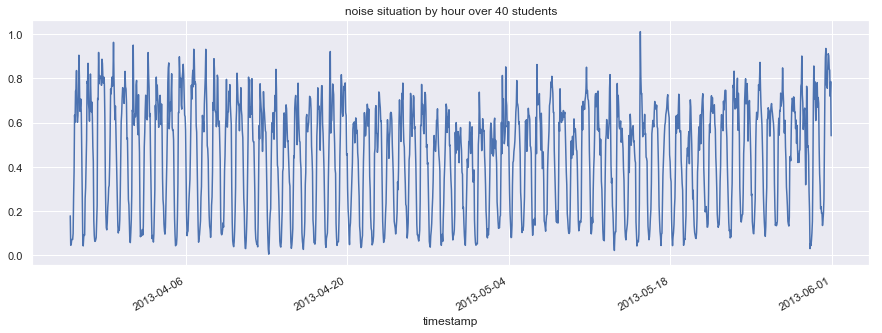

In [418]:
sns.set(rc={'figure.figsize':(15,5)})
ax = audio_time_df_hour.mean().plot.line(legend=False,title = 'noise situation by hour over 40 students')
save_result_fig(ax,'audio_time_df_hour')

### moving average

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00'],
              dtype='datetime64[ns]', freq='H')


([<matplotlib.axis.XTick at 0x1c14a50a58>,
 <a list of 5 Text xticklabel objects>)

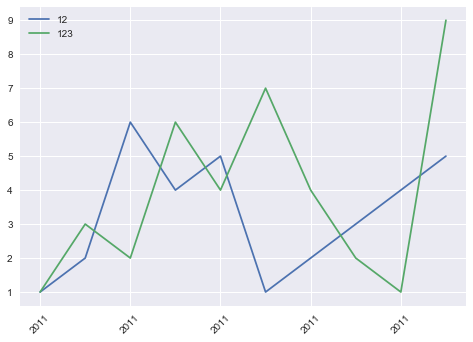

In [218]:
plt.style.use('seaborn')

plttest = pd.DataFrame([1,2,6,4,5,1,2,3,4,5],index = pd.date_range('1/1/2011', periods=10, freq='H'))
plttest1 = pd.DataFrame([1,3,2,6,4,7,4,2,1,9],index = pd.date_range('1/1/2011', periods=10, freq='H'))
name = [plttest,plttest1]
print(plttest.index)
frequency = 2
# for i in range(2):
plt.plot(name[i].index,plttest.values,label='12')
plt.plot(name[1].index,plttest1.values,label='123')
plt.legend()
plt.xticks(list(plttest.index)[::frequency], rotation=45)#[::frequency]


In [261]:
activity_time_df_hour.columns

DatetimeIndex(['2013-03-27 00:00:00-04:00', '2013-03-27 01:00:00-04:00',
               '2013-03-27 02:00:00-04:00', '2013-03-27 03:00:00-04:00',
               '2013-03-27 04:00:00-04:00', '2013-03-27 05:00:00-04:00',
               '2013-03-27 06:00:00-04:00', '2013-03-27 07:00:00-04:00',
               '2013-03-27 08:00:00-04:00', '2013-03-27 09:00:00-04:00',
               ...
               '2013-05-31 14:00:00-04:00', '2013-05-31 15:00:00-04:00',
               '2013-05-31 16:00:00-04:00', '2013-05-31 17:00:00-04:00',
               '2013-05-31 18:00:00-04:00', '2013-05-31 19:00:00-04:00',
               '2013-05-31 20:00:00-04:00', '2013-05-31 21:00:00-04:00',
               '2013-05-31 22:00:00-04:00', '2013-05-31 23:00:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='timestamp', length=1584, freq='H')

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>
succesfully sve file to ../results/Trend of activity level and number of deadline.png


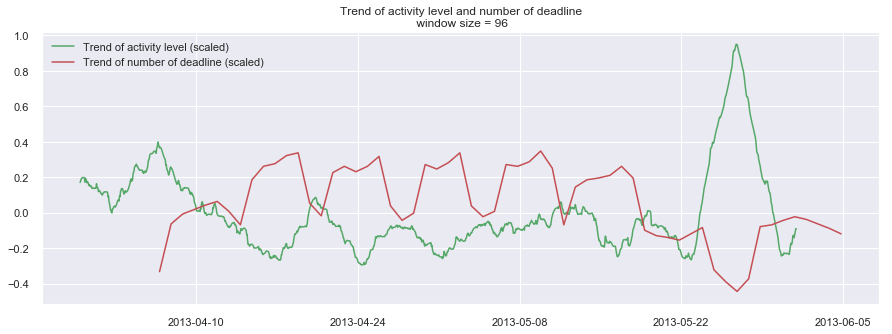

In [385]:


scaler = StandardScaler()
ww =96
activity_time_df_hour_series = activity_time_df_hour.mean()

# plot_moving_average(audio_time_df_hour_series,ww,'audio_time_df_hour_series_moving_average')
# plot_moving_average(deadlines.sum(),12,'deadlines_moving_average')

plt.figure(figsize=(15,5))


# sub line title
title = 'Trend of activity level and number of deadline'

# scale data
activity_data = scaler.fit_transform(activity_time_df_hour_series.values.reshape(-1, 1))
# put it back into series
activity_moving_avg = pd.Series(activity_data.reshape(-1),index = audio_time_df_hour_series.index)
rolling_mean = activity_moving_avg.rolling(window=ww).mean()
plt.title("{}\n window size = {}".format(title,ww))

label_activity = 'Trend of activity level (scaled)'


# X ticks
frequency = 72
date = ['%s-%s'%(i.month,i.day) for i in rolling_mean.index.date]# rolling_mean.index.date
pd.Timedelta(days = 0)
plt.plot(rolling_mean.index,rolling_mean.values, "g", label=label_activity)
# plt.xticks(date[::frequency], rotation=45)

# scale data
ddl_data = scaler.fit_transform(deadlines.sum().values.reshape(-1, 1))
# put it back into series
deadline_moving_avg = pd.Series(ddl_data.reshape(-1),index = deadlines.sum().index)

label_ddl = 'Trend of number of deadline (scaled)'
rolling_mean_ddl = deadline_moving_avg.rolling(window=12
                                              ).mean()


# Top Secret! add hour infor into date index of deadline,so that it can mathc with hourly based time.
rolling_mean_ddl.index = [pd.to_datetime(i) for i in rolling_mean_ddl.index]

plt.plot(rolling_mean_ddl.index,rolling_mean_ddl.values, "r", label=label_ddl
        )

plt.legend()
save_result_fig(plt,title)
plt.show()

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>
succesfully sve file to ../results/Trend of noise level and number of deadline.png


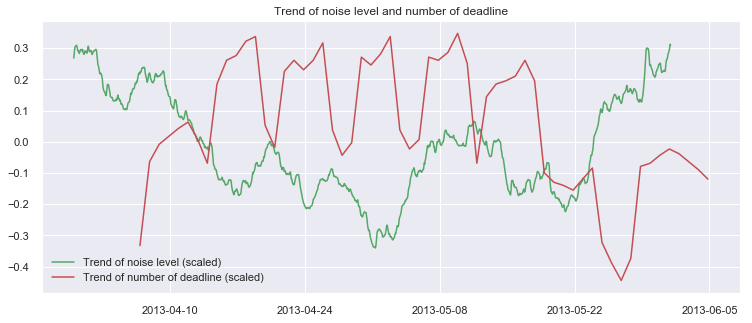

In [352]:
scaler = StandardScaler()
ww =96
audio_time_df_hour_series = audio_time_df_hour.mean()

# plot_moving_average(audio_time_df_hour_series,ww,'audio_time_df_hour_series_moving_average')
# plot_moving_average(deadlines.sum(),12,'deadlines_moving_average')

plt.figure(figsize=(12.5,5))


# sub line title
title = 'Trend of noise level and number of deadline'

# scale data
audio_data = scaler.fit_transform(audio_time_df_hour_series.values.reshape(-1, 1))
# put it back into series
audio_moving_avg = pd.Series(audio_data.reshape(-1),index = audio_time_df_hour_series.index)

rolling_mean = audio_moving_avg.rolling(window=ww).mean()
plt.title(title) # "{}\n window size = {}".format(title,ww)


label_noise = 'Trend of noise level (scaled)'
# X ticks
frequency = 72
date = ['%s-%s'%(i.month,i.day) for i in rolling_mean.index.date]# rolling_mean.index.date
pd.Timedelta(days = 0)
plt.plot(rolling_mean.index,rolling_mean.values, "g", label=label_noise)
# plt.xticks(date[::frequency], rotation=45)

# scale data
ddl_data = scaler.fit_transform(deadlines.sum().values.reshape(-1, 1))
# put it back into series
deadline_moving_avg = pd.Series(ddl_data.reshape(-1),index = deadlines.sum().index)

label_ddl = 'Trend of number of deadline (scaled)'
rolling_mean_ddl = deadline_moving_avg.rolling(window=12
                                              ).mean()



rolling_mean_ddl.index = [pd.to_datetime(i) for i in rolling_mean_ddl.index]
# date_ddl = rolling_mean_ddl.index
# rolling_mean_ddl.index = pd.to_datetime(rolling_mean_ddl.index)
# print(rolling_mean_ddl.index)
# loop_date=[]
# for i, xi in enumerate(date):
#     if xi in loop_date:
#         w.insert(i, None)
#         rolling_mean_ddl = rolling_mean_ddl.set_value(i, None)
plt.plot(rolling_mean_ddl.index,rolling_mean_ddl.values, "r", label=label_ddl)
save_result_fig(plt,title)
plt.legend()
plt.show()


#### Calculate granger causality

In [256]:
len(list(rolling_mean_ddl.dropna().values))
len(list(rolling_mean.dropna().values))

1578

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
ddl_list = list(rolling_mean_ddl.dropna().values)
rolling_mean.d
grangercausalitytests([])

AxesSubplot(0.125,0.125;0.775x0.755)
succesfully sve file to ../results/audio_time_df_hour_week.png


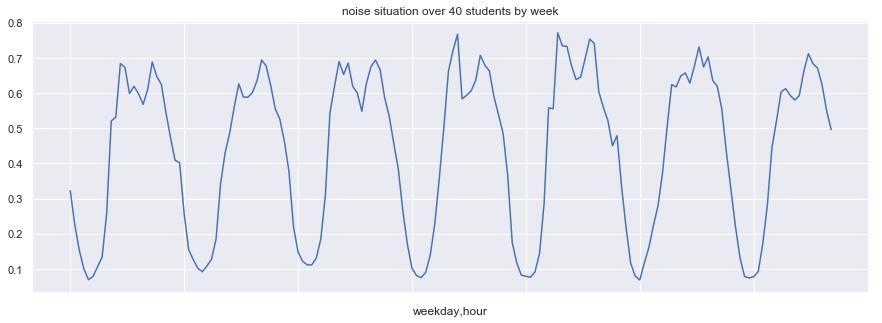

In [300]:
# week summary for audio data
audio_time_df_hour_pure = audio_time_df_hour[audio_time_df_hour.columns[:-6]]
audio_time_df_hour_week = create_group_by_df(audio_time_df_hour_pure,group_by = 'both')
sns.set(rc={'figure.figsize':(15,5)})
ax = audio_time_df_hour_week.mean().plot.line(legend=False,title = 'noise situation over 40 students by week')
# ax.set_xticklabels(audio_time_df_week.columns, rotation=45)
save_result_fig(ax,'audio_time_df_hour_week')


In [295]:
def split_df_by_cluster(df):
    # create 3 sub df
    # return a dict, key = cluster number, value = df
    clustered_audio_week = {0:pd.DataFrame(),1:pd.DataFrame(),2:pd.DataFrame()}
    # fill in with different students
    for index, row in df.iterrows():
        if index[-3:] in USER_ID2CLUSER: 
            cluster_id = USER_ID2CLUSER[index[-3:]]
            clustered_audio_week[cluster_id]= clustered_audio_week[cluster_id].append(row)
    return clustered_audio_week

In [296]:
def tuple_to_tick(list_of_tuple):
    weekdays = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    xtick = []
    for tup in list_of_tuple:
        xtick.append('%s %s:00'%(weekdays[tup[0]],tup[1]))
    return xtick


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>
succesfully sve file to ../results/clustered_audio_week_rolling.png


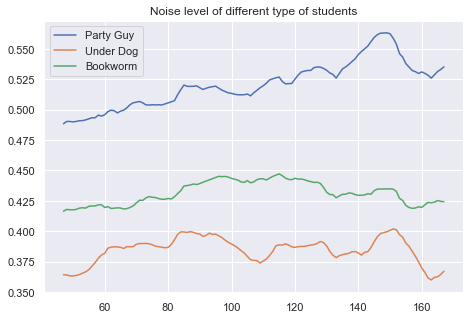

In [303]:
ww = 48
tick_freq = 24
plt.figure(figsize=(7.5,5))
clustered_audio_week = split_df_by_cluster(audio_time_df_hour_week)

title = 'Noise level of different type of students'
plt.title(title) #"{}\n window size = {}".format(title,ww)
clustered_audio_week_rolling = {}
for cluster_id, df in clustered_audio_week.items():
#     plot_moving_average(df.mean(),ww,'audio_time_df_hour_week_')
    
    rolling_mean = df.mean().rolling(window=ww).mean()
#     print(rolling_mean)
#     break
    clustered_audio_week_rolling[cluster_id] = rolling_mean
clustered_audio_week[0].columns
plt.plot(clustered_audio_week_rolling[0].values, label='Party Guy')
plt.plot(clustered_audio_week_rolling[1].values, label='Under Dog')
plt.plot(clustered_audio_week_rolling[2].values, label='Bookworm')

plt.legend()


indexes = tuple_to_tick(clustered_audio_week_rolling[0].index)
save_result_fig(plt,'clustered_audio_week_rolling')
# _=plt.xticks(list(range(168))[::tick_freq],[i[:-5] for i in indexes[::tick_freq]])# , rotation=90

In [369]:
audio_time_df_only_hour.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
audio_u00,0.756498,0.621427,0.408739,0.233296,0.200867,0.133289,0.160275,0.138390,0.139882,0.160778,...,0.859579,0.950619,0.982109,0.959317,1.016333,1.092532,1.061571,0.987938,1.063770,0.938120
audio_u01,0.871216,0.750024,0.782175,0.772857,0.690942,0.569176,0.377061,0.250069,0.148036,0.126306,...,0.354534,0.468187,0.707742,0.961566,0.932738,0.919417,0.851085,0.847307,0.902236,0.869961
audio_u02,0.552892,0.539680,0.582576,0.557784,0.440526,0.246188,0.144725,0.033740,0.024719,0.014178,...,0.501080,0.721223,0.810752,0.481116,0.437920,0.433813,0.498357,0.601635,0.755918,0.669573
audio_u03,0.064145,0.071476,0.122899,0.067063,0.045190,0.016482,0.011791,0.007854,0.001562,0.002365,...,0.295402,0.321081,0.240204,0.303739,0.312283,0.208806,0.103000,0.133632,0.120539,0.108065
audio_u04,1.122567,1.006024,0.900717,0.552360,0.335857,0.084653,0.026008,0.015016,0.042230,0.092816,...,1.031743,1.225795,1.082051,1.163310,1.067034,1.088419,1.000857,1.025140,1.138354,1.029318


AxesSubplot(0.125,0.125;0.775x0.755)
succesfully sve file to ../results/audio_time_df_only_hour.png


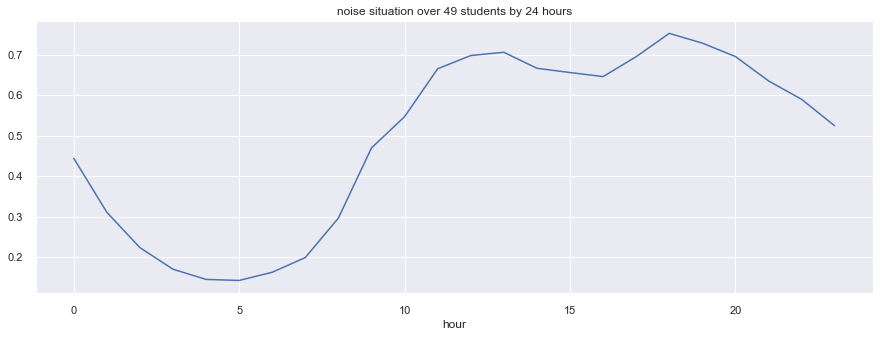

In [63]:
# week summary for audio data
audio_time_df_only_hour = create_group_by_df(audio_time_df_hour,group_by='hour')
sns.set(rc={'figure.figsize':(15,5)})
ax = audio_time_df_only_hour.mean().plot.line(legend=False,title = 'noise situation over 49 students by 24 hours')
# ax.set_xticklabels(audio_time_df_week.columns, rotation=45)
save_result_fig(ax,'audio_time_df_only_hour.png')

Test MSE: 0.009


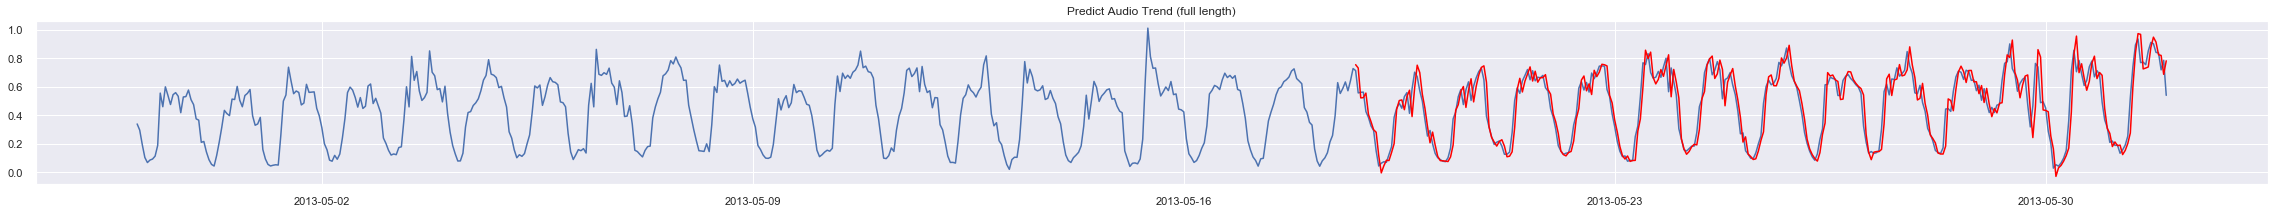

In [381]:
plt_predict_audio_full = predict_time_series_ARIMA(audio_time_df_hour.mean(),title = 'Predict Audio Trend (full length)',fig_size = (40,3),split_size = 0.8,full = True)
plt_predict_audio_full.savefig(result_path+'predict_audio_trend_full.png')
plt_predict_audio_full.show()

Test MSE: 0.010


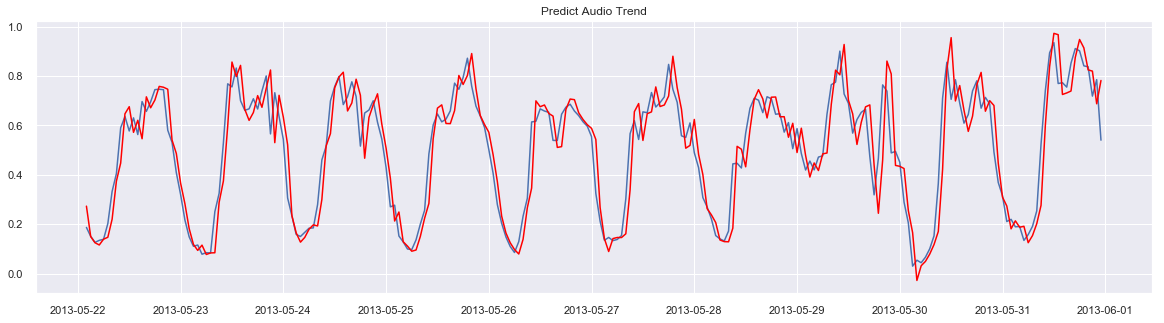

In [382]:
plt_predict_audio = predict_time_series_ARIMA(audio_time_df_hour.mean(),title = 'Predict Audio Trend',fig_size = (20,5),split_size = 0.85)
plt_predict_audio.savefig(result_path+'predict_audio_trend_sub.png')
plt_predict_audio.show()

Test MSE: 0.001


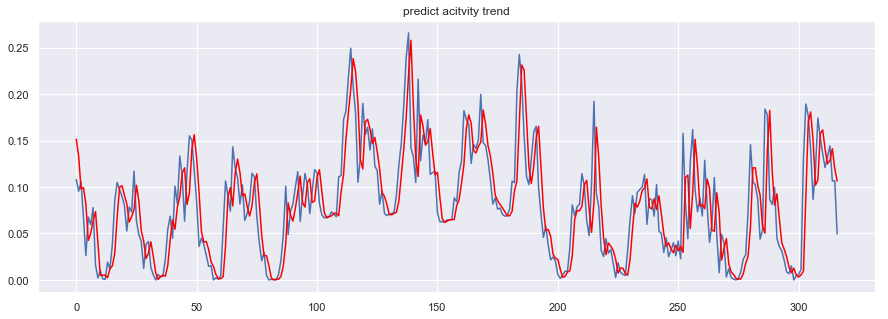

In [429]:
plt_predict_acti = predict_time_series_ARIMA(activity_time_df_hour.mean(),'Activity',split_size = 0.8)
plt_predict_acti.savefig(result_path+'predict_activity_time_df_hour.png')
plt_predict_acti.show()
# plt_predict_acti.savefig(result_path+'predict_activity_time_df_hour.png')
# save_result_fig(plt_predict_acti,'predict_activity_time_df_hour.png')

### 1.2 Activity data

In [21]:
activity_time_df_hour = create_time_df(activity_path,unit = 'H')

AxesSubplot(0.125,0.2;0.775x0.68)
succesfully sve file to ../results/activity_time_df_hour.png


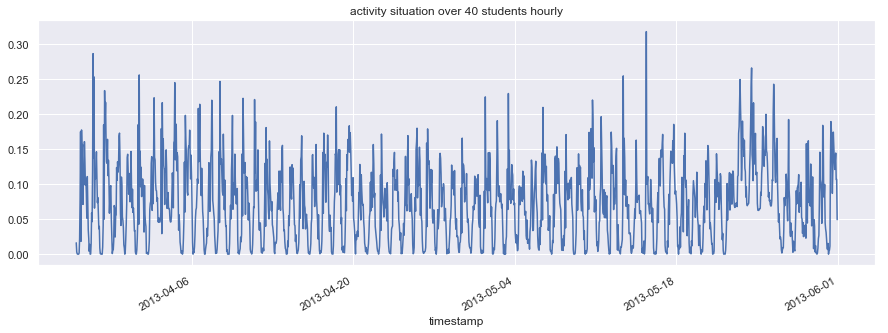

In [22]:

sns.set(rc={'figure.figsize':(15,5)})
ax = activity_time_df_hour.mean().plot.line(legend=False,title = 'activity situation over 40 students hourly')
save_result_fig(ax,'activity_time_df_hour.png')

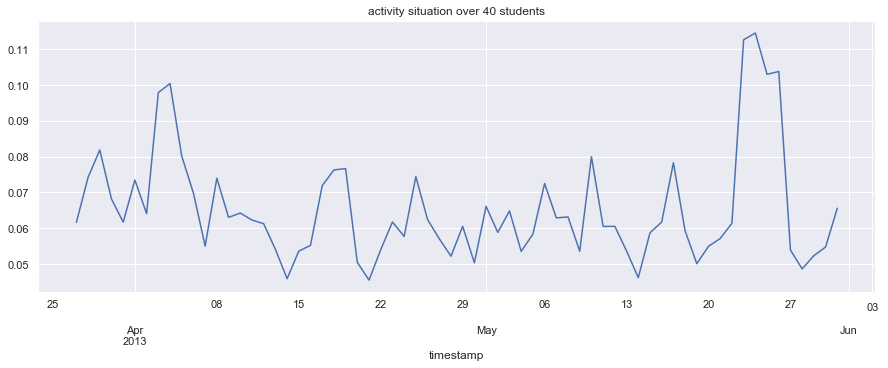

In [145]:
activity_time_df = create_time_df(activity_path,unit = 'D')
sns.set(rc={'figure.figsize':(15,5)})
activity_time_df.mean().plot.line(legend=False,title = 'activity situation over 40 students')

Test MSE: 0.001


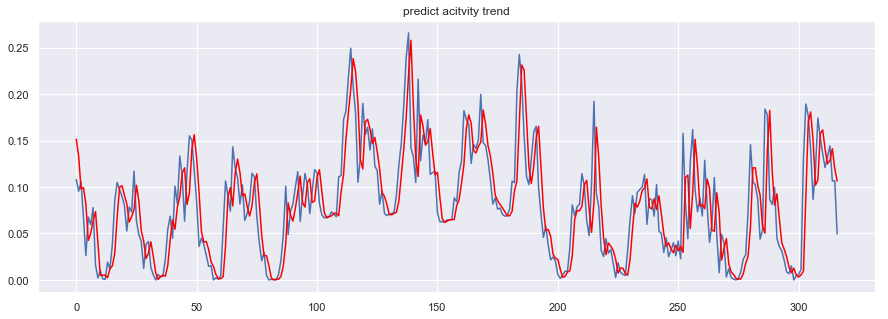

In [150]:
plt_predict_activity = predict_time_series_ARIMA(activity_time_df.mean(),'Activity',split_size = 0.8)
plt_predict_activity.savefig(result_path+'predict-tmp.png')
plt_predict_activity.show()

AxesSubplot(0.125,0.125;0.775x0.755)
succesfully sve file to ../results/activity_time_df_hour_week.png


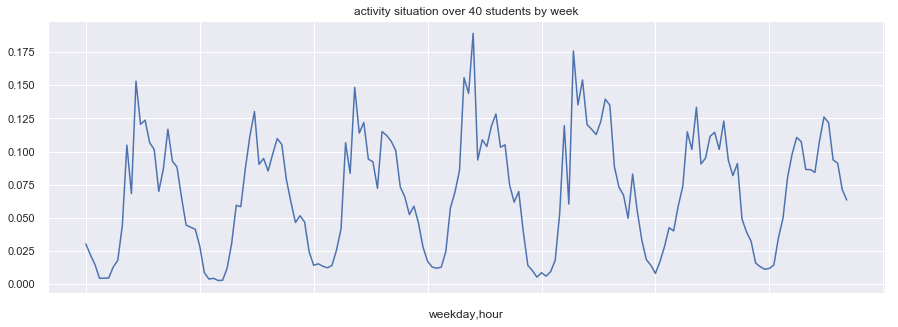

In [279]:
activity_time_df_hour_week = create_group_by_df(activity_time_df_hour, group_by = 'both')
sns.set(rc={'figure.figsize':(15,5)})
ax = activity_time_df_hour_week.mean().plot.line(legend=False,title = 'activity situation over 40 students by week')
save_result_fig(ax,'activity_time_df_hour_week.png')

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>
succesfully sve file to ../results/Activity level of different type of students.png


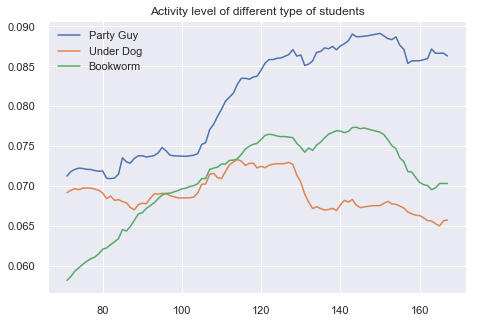

In [384]:

ww = 72
tick_freq = 24
plt.figure(figsize=(7.5,5))
clustered_activity_week = split_df_by_cluster(activity_time_df_hour_week)

title = 'Activity level of different type of students'

plt.title(title) # "{}\n window size = {}".format(title,ww)
clustered_activity_week_rolling = {}
for cluster_id, df in clustered_activity_week.items():
#     plot_moving_average(df.mean(),ww,'audio_time_df_hour_week_')
    
    rolling_mean = df.mean().rolling(window=ww).mean()
#     print(rolling_mean)
#     break
    clustered_activity_week_rolling[cluster_id] = rolling_mean
clustered_audio_week[0].columns
plt.plot(clustered_activity_week_rolling[0].values, label='Party Guy')
plt.plot(clustered_activity_week_rolling[1].values, label='Under Dog')
plt.plot(clustered_activity_week_rolling[2].values, label='Bookworm')

plt.legend()
save_result_fig(plt,title)

indexes = tuple_to_tick(clustered_activity_week_rolling[0].index)
# _=plt.xticks(list(range(168))[::tick_freq],[i[:-5] for i in indexes[::tick_freq]])# , rotation=90

### 1.3 Education data

#### Piazza data

In [292]:
# sns.set(rc={'figure.figsize':(15,5)})
# piazza = pd.read_csv(education_path+'piazza.csv',index_col = 0)
# scaler = StandardScaler()
# piazza_scale = piazza
# piazza_scale[piazza.columns] = scaler.fit_transform(piazza[piazza.columns])
# piazza.transpose().mean().plot(x = row_, y = col_,legend = False)
# ax = piazza.mean().plot()
# ax.set_xticklabels(piazza.columns, rotation=45)
# plt.setp(ax.xaxis.get_majorticklabels(), ha='left')
piazza.describe()

,days online,views,contributions,questions,notes,answers
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,42.489796,210.020408,25.612245,3.244898,3.816327,3.408163
std,20.181595,97.784732,89.470623,5.080726,16.157652,11.725894
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,147.000000,1.000000,0.000000,0.000000,0.000000
50%,43.000000,226.000000,6.000000,1.000000,0.000000,0.000000
75%,58.000000,299.000000,20.000000,4.000000,1.000000,2.000000
max,82.000000,399.000000,620.000000,22.000000,93.000000,79.000000


#### Deadline time series

In [114]:
deadlines = pd.read_csv(education_path+'deadlines.csv',index_col = 0)
deadlines  = deadlines.dropna(axis = 1)

AxesSubplot(0.125,0.125;0.775x0.755)
succesfully sve file to ../results/deadlines_time_df_day.png


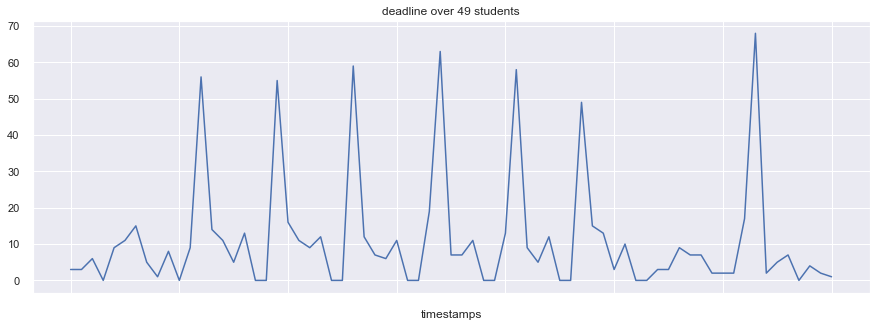

In [115]:
sns.set(rc={'figure.figsize':(15,5)})
ax = deadlines.sum().plot.line(legend=False,title = 'deadline over 49 students')
ax.set_xlabel('timestamps')
save_result_fig(ax,'deadlines_time_df_day.png')

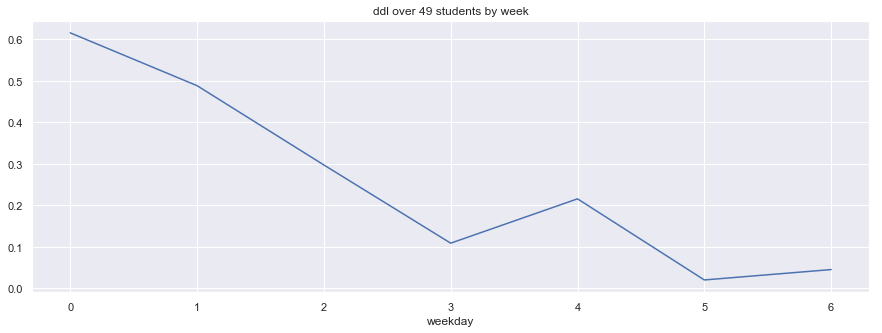

In [336]:
deadline_week  = create_group_by_df(deadlines)
deadline_week.mean().plot.line(legend=False,title = 'ddl over 49 students by week')

In [307]:
grades = pd.read_csv(education_path+'/grades.csv', index_col = 0)
grades_clustered = split_df_by_cluster(grades)

for key,df in grades_clustered.items():
    print(df.shape)
grades_clustered[0].columns

(8, 3)
(5, 3)
(11, 3)


Index([' cs 65', ' gpa 13s', ' gpa all'], dtype='object')

In [351]:
# grade_cluster_df = pd.DataFrame(columns = grades_clustered[0].columns)
# names_grade = ['party_guy','underdog','bookworm']
# for i,each in enumerate(grades_clustered):
#     grade_cluster_df.loc[names_grade[i]] = grades_clustered[each].mean()
# grade_cluster_df.columns = [ i.strip() for i in grade_cluster_df.columns]
grade_cluster_df.columns =['course grade',grade_cluster_df.columns[1],grade_cluster_df.columns[2]]
grade_cluster_df

,course grade,gpa 13s,gpa all
party_guy,3.833333,3.440972,3.403125
underdog,4.000000,3.177778,3.462400
bookworm,3.272727,3.353535,3.405818


In [309]:
grades_clustered[0].mean()
# bad flourish

 cs 65      3.833333
 gpa 13s    3.440972
 gpa all    3.403125
dtype: float64

In [344]:
grades_clustered[1]
# underdog

,cs 65,gpa 13s,gpa all
u07,4.0,4.000000,3.474
u16,4.0,4.000000,3.373
u17,4.0,3.333333,3.476
u46,4.0,1.111111,3.646
u54,4.0,3.444444,3.343


In [346]:
grades_clustered[2]
# lonely

,cs 65,gpa 13s,gpa all
u02,4.000000,4.000000,3.505
u09,3.666667,3.777778,3.806
u10,4.000000,3.777778,3.667
u15,3.666667,3.333333,2.815
u18,3.333333,3.333333,3.474
u19,3.333333,3.777778,3.947
u24,3.333333,3.222222,2.987
u27,3.000000,3.333333,3.719
u49,4.000000,3.777778,3.625
u52,0.000000,1.000000,2.400


extract silence count(0) and voice count (conversation:1) and noisy environment(2) 

#### 1.4 conversation data

## 2 Feature extration


In [392]:
def clean_index_for_combine(df):
    indexes = list(df.index)
    if '_u' in str(indexes[0]):
        df.index = [id_[-3:] for id_ in df.index]
    elif 'u00' ==indexes[0]:
        pass
    else:
        df.index = ['u'+CLUSTER_ID2USER_ID[int(str(id_))] for id_ in df.index]
    return df

In [393]:
def create_feature_mean_std(df_hour, name, unit = 'hour'):
    df_hour.name = name
    # different split param in order to devide into 3 parts
    if unit =='hour':
        split = 530
    elif unit == 'day':
        split = 23
        
    df_hour_w_feature = df_hour

    # split into equal size chunks and calculate mean and std.
    for g, df in df_hour.transpose().groupby(np.arange(len(df_hour.transpose())) // split):

        print(g,df.shape)
        df_hour_w_feature['%s_%s_mean'%(name,g)]=df.mean()
        df_hour_w_feature['%s_%s_std'%(name,g)]=df.std()
        
    return df_hour_w_feature[df_hour_w_feature.columns[-6:]]


In [396]:
audio_time_df_hour = clean_index_for_combine(audio_time_df_hour)
audio_feature = create_feature_mean_std(audio_time_df_hour, name ='audio', unit = 'hour')
audio_feature.index[0]

0 (530, 49)
1 (530, 49)
2 (524, 49)


'u00'

In [397]:
lock_daily=clean_index_for_combine(lock_daily)
lock_daily_feature = create_feature_mean_std(lock_daily,name = 'ld',unit = 'day')

0 (23, 40)
1 (23, 40)
2 (15, 40)


In [398]:
sleep_time = clean_index_for_combine(sleep_time)
sleep_time_feature = create_feature_mean_std(sleep_time,name = 'st',unit = 'day')

0 (23, 40)
1 (23, 40)
2 (15, 40)


In [404]:
# sleep_time_feature

In [399]:
ld_au_feature = pd.concat([audio_feature,lock_daily_feature], axis=1)
ld_au_feature.shape

(49, 12)

In [400]:
ld_au_st_feature = pd.concat([audio_feature,lock_daily_feature,sleep_time_feature], axis=1)
ld_au_st_feature.shape

(49, 18)

### Split train & test dataset

#### Add type column as Y

In [230]:
def str_ (num):
    if int(num)<10:
        return '0'+str(num)
    else:
        return str(num)

In [231]:
def split_train_test_(df):
    X_train, X_test, y_train, y_test = (
    train_test_split(df[df.columns[:-1]],
                    df[df.columns[-1]],
                    test_size=0.2,
                    random_state = 0))

    print(len(X_train),len(X_test))
    return X_train, X_test, y_train, y_test

In [232]:
# not using
def fill_nan(x_train, strategy='mean'):
    # Create our imputer to replace missing values with the mean e.g.
    imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
    imp = imp.fit(x_train)

    # Impute our data, then train
    X_train_imp = imp.transform(x_train)
    return X_train_imp

In [233]:
# in use
def map_id(id_):
    if id_ in CLUSTER_ID2USER_ID:
        return CLUSTER_ID2USER_ID[id_]
    else:
        return None

In [234]:
# in use
def change_type(y_train):
    return y_train.astype('float64')

In [319]:
# recently added
grades = pd.read_csv(education_path+'/grades.csv', index_col = 0)
grades.columns = [i.strip() for i in grades.columns]
def generate_X_y(df_feature, gpa=False):
    """input: only x"""
    
    if gpa:
        df_feature['gpa'] = '-'
        # user = (clusterID,clusterID)
        for i,user in grades.iterrows():
            df_feature.loc[user.name,'gpa'] = user['cs 65']
        df_feature = df_feature[df_feature['gpa']!='-']
 
    else:
        df_feature['type'] = '-'
        # user = (clusterID,clusterID)
        for user in CLUSTER_USER:
            # get user ID
            id_user = map_id(user[0])
            df_feature.loc['u'+id_user,'type'] = user[1]
        df_feature = df_feature[df_feature['type']!='-']
        print(len(df_feature))

    user_mean = df_feature.mean(axis=1).to_dict()
    # fill na:
    X_df_feature_whole = df_feature[df_feature.columns[:-1]].transpose().fillna(user_mean).transpose()
    y_df_feature_whole = change_type(df_feature[df_feature.columns[-1]])
    
    return X_df_feature_whole, y_df_feature_whole

In [271]:
whole_result = pd.concat([conversation_result,a_result,phone_all,gps_all],axis =1)
whole_result = whole_result.drop(columns=['uid'])
X_whole_psy,y_whole_psy = generate_X_y(whole_result)

40


In [277]:
gnb_model_0 = GaussianNB(var_smoothing=0.01) # MultinomialNB(alpha=2) GaussianNB(var_smoothing=0.1)
rf_model = RandomForestClassifier(n_estimators=30,oob_score=True, criterion='entropy')
np.mean(cross_vali(gnb_model_0,X_whole_psy,y_whole_psy))


----- 3 0.4743589743589743
----- 4 0.4736111111111111
----- 5 0.4634920634920635
----- 7 0.4391156462585034
----- 10 0.44000000000000006


0.4581155590441305

In [286]:
X_whole_psy.head()

,cov_count_before,cov_count_after,cov_mean_before,cov_mean_after,audio_before,audio_after,activity_before,activity_after,before_charge,after_charge,...,before_sleep,after_sleep,before_play_dark,after_play_dark,before_sleep_dark,after_sleep_dark,weekend_locvar,weekday_locvar,before_moving,after_moving
u00,32.277778,31.633333,14.137514,11.515206,32.277778,31.633333,14.137514,11.515206,6.907980,6.244295,...,5.169559,4.987853,14.464984,18.061865,5.196797,3.815734,-1.734485,-2.162183,16.685714,15.961538
u01,37.750000,29.285714,12.734380,10.220096,37.750000,29.285714,12.734380,10.220096,7.425152,7.372500,...,7.288725,6.595863,10.872682,13.181389,6.220295,5.339788,-2.302554,-2.302559,16.428571,23.181818
u02,23.722222,20.966667,14.371453,13.411877,23.722222,20.966667,14.371453,13.411877,7.585185,6.145208,...,5.126701,4.443825,13.683811,15.224252,7.037578,5.630929,-2.286666,-2.300463,9.600000,21.115385
u03,9.638889,6.550000,8.416439,4.214764,9.638889,6.550000,8.416439,4.214764,8.299505,7.817500,...,6.703492,4.945583,15.297417,15.292049,5.470597,6.023958,-2.302580,-2.302579,5.080000,3.500000
u04,46.138889,48.909091,9.828091,8.665249,46.138889,48.909091,9.828091,8.665249,7.659892,7.540278,...,7.226574,7.100355,9.478562,9.631930,6.877917,6.324225,-2.302508,-2.302410,27.735294,24.666667


In [306]:
# gnb_model_0.fit(X_whole_psy,y_whole_psy)
gnb_model_0.class_count_, gnb_model_0.sigma_,gnb_model_0.class_prior_

(array([13.,  9., 18.]),
 array([[ 72.44749147,  70.8083596 ,  15.2639099 ,  14.5413398 ,
          72.44749147,  70.8083596 ,  15.2639099 ,  14.5413398 ,
           2.60434575,   4.78277563,   4.98673235,   4.99083071,
           2.13084814,   2.08239594,   6.46585118,   6.54058771,
           2.08791372,   1.85286389,   1.53004225,   1.39357883,
          41.21856529,  59.16209734],
        [ 21.4701522 ,  56.15420873,   6.80112192,   8.26781904,
          21.4701522 ,  56.15420873,   6.80112192,   8.26781904,
           3.63983076,   5.21387879,   5.48183191,   9.94818663,
           2.37361489,   3.04068135,   5.94128952,   8.60883779,
           2.26513109,   2.67180478,   1.39477972,   1.41190189,
           6.15213445,  17.98453803],
        [112.03159005, 223.7252252 ,   6.10311574,   9.83256331,
         112.03159005, 223.7252252 ,   6.10311574,   9.83256331,
           3.74039472,   9.2567025 ,  10.20636501,   8.58957677,
           2.89084529,   4.70401325,   5.36580001,   5

In [327]:
gnb_model_0.sigma_.mean(axis=0)

array([ 68.64974457, 116.89593118,   9.38938252,  10.88057405,
        68.64974457, 116.89593118,   9.38938252,  10.88057405,
         3.32819041,   6.41778564,   6.89164309,   7.8428647 ,
         2.46510277,   3.27569685,   5.92431357,   6.94451558,
         2.74572863,   2.90702638,   1.4446997 ,   1.4004549 ,
        20.50248321,  39.05888109])

In [329]:
gnb_model_0.theta_.mean(axis=0)

array([27.97855036, 23.70196506, 10.5125349 ,  8.59465182, 27.97855036,
       23.70196506, 10.5125349 ,  8.59465182,  6.61574101,  5.71754138,
       12.67821095, 14.32872754,  5.98209349,  5.59957563, 13.95598137,
       14.87766002,  5.77780526,  5.40608147, -2.19056317, -2.26203568,
       11.91668621, 12.42245135])

In [304]:
X_whole_psy.columns

Index(['cov_count_before', 'cov_count_after', 'cov_mean_before',
       'cov_mean_after', 'audio_before', 'audio_after', 'activity_before',
       'activity_after', 'before_charge', 'after_charge', 'before_play',
       'after_play', 'before_sleep', 'after_sleep', 'before_play_dark',
       'after_play_dark', 'before_sleep_dark', 'after_sleep_dark',
       'weekend_locvar', 'weekday_locvar', 'before_moving', 'after_moving'],
      dtype='object')

In [320]:
whole_result = pd.concat([conversation_result,a_result,phone_all,gps_all],axis =1)
whole_result = whole_result.drop(columns=['uid'])
X_whole_gpa,y_whole_gpa = generate_X_y(whole_result,gpa=True)

In [348]:
from sklearn.linear_model import Lasso
#train score
clf = Lasso(alpha=0.1)
# clf.fit(X_train_fillna,y_train)
# y_pred = clf.predict(X_test_fillna)
# model = SelectFromModel(lsvc, prefit=True)
np.mean(cross_vali(clf,X_whole_gpa,y_whole_gpa,'neg_mean_squared_error',regression= True)),\
      np.mean(cross_vali(clf,X_whole_gpa,y_whole_gpa,'neg_mean_absolute_error',regression= True))

----- 3 -1.1860937577893682
----- 4 -1.2096856125625985
----- 5 -1.3410984076383783
----- 7 -1.3595064445629907
----- 10 -1.2561683786612192
----- 3 -0.7665567690941147
----- 4 -0.7616436989808884
----- 5 -0.8498507542994268
----- 7 -0.8491302674165174
----- 10 -0.8026789630903073


(-1.2705105202429112, -0.8059720905762511)

In [305]:
X_whole_gpa.columns

Index(['cov_count_before', 'cov_count_after', 'cov_mean_before',
       'cov_mean_after', 'audio_before', 'audio_after', 'activity_before',
       'activity_after', 'before_charge', 'after_charge', 'before_play',
       'after_play', 'before_sleep', 'after_sleep', 'before_play_dark',
       'after_play_dark', 'before_sleep_dark', 'after_sleep_dark',
       'weekend_locvar', 'weekday_locvar', 'before_moving', 'after_moving'],
      dtype='object')

In [324]:
# clf.fit(X_whole_gpa,y_whole_gpa)
c = [round(i,3) for i in clf.coef_]
np.array(c)


array([ 0.039, -0.   ,  0.   ,  0.059,  0.003, -0.   ,  0.   ,  0.   ,
       -0.   ,  0.   ,  0.035,  0.   ,  0.   , -0.013, -0.038, -0.043,
        0.03 , -0.   ,  0.008,  0.   ,  0.005, -0.055])

In [290]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [340]:
X_whole_psy.shape

(40, 22)

In [347]:
scaler = StandardScaler()

# scale data
X_whole_psy_scale = scaler.fit_transform(X_whole_psy.values.reshape(-1, 1))
# put it back into series
X_whole_psy_scale = pd.DataFrame(X_whole_psy_scale.reshape(40, 22),index = X_whole_psy.index)

gnb_model_1 = GaussianNB(var_smoothing=0.01) # MultinomialNB(alpha=2) GaussianNB(var_smoothing=0.1)
rf_model = RandomForestClassifier(n_estimators=30,oob_score=True, criterion='entropy')
np.mean(cross_vali(gnb_model_1,X_whole_psy_scale,y_whole_psy))


----- 3 0.4743589743589743
----- 4 0.4736111111111111
----- 5 0.4634920634920635
----- 7 0.4391156462585034
----- 10 0.44000000000000006


0.4581155590441305

split X and y

In [414]:
X_au_whole,y_au_whole = generate_X_y(audio_time_df_hour)

In [419]:
X_st_whole,y_st_whole = generate_X_y(sleep_time)

In [420]:
X_ld_whole,y_ld_whole = generate_X_y(lock_daily)

In [423]:
X_au_feature_whole,y_au_feature_whole = generate_X_y(audio_feature)

In [432]:
X_st_feature_whole,y_st_feature_whole = generate_X_y(sleep_time)

In [424]:
X_ld_feature_whole,y_ld_feature_whole = generate_X_y(lock_daily_feature)

In [425]:
X_ld_au_feature_whole,y_ld_au_feature_whole = generate_X_y(ld_au_feature)

In [50]:
# X_train, X_test, y_train, y_test = split_train_test_(pd.concat([X_au_feature_whole,y_au_feature_whole],axis = 1))

32 8


In [418]:
# pd.concat([X_au_feature_whole,y_au_feature_whole],axis = 1)

In [74]:
gnb_model_0 = GaussianNB(var_smoothing=0.1) # MultinomialNB(alpha=2)
gnb_model_0.fit(X_train,y_train)
y_pred = gnb_model_0.predict(X_test)
print(y_test)
print(y_pred)
accuracy_score(y_test,y_pred)

u33    0.0
u31    2.0
u36    1.0
u04    0.0
u15    2.0
u20    1.0
u44    1.0
u16    1.0
Name: type, dtype: float64
[0. 2. 2. 0. 0. 2. 2. 2.]


0.375

In [345]:
def my_custom_loss_func(Y, y ):
#     print(list(Y))
#     print(list(y))
#     print()
#     return accuracy_score(Y, y)
    accu = sum([1 for i in range(len(Y)) if Y[i]==y[i]])
    return float(accu)/len(Y)
scoring_ = make_scorer(my_custom_loss_func) # , greater_is_better=False
                          
                

#     print(list(Y))
#     print(list(y))
#     print()
          
#     accu = sum([1 for i in range(len(Y)) if Y[i]==y[i]])
#     print(accu, len(y),accu/len(Y))
#     return precision_score(Y, y, average = None)

#     return accu/len(Y)

In [346]:
# def cross_vali(model,X_feature_whole,y_feature_whole, split_list = [3,4,5,7,10]):
#     scores = []
#     for cv_score in split_list:
#         score = cross_validate(model, X_feature_whole, y_feature_whole, 
#                                scoring = {'accuracy': scoring_},
#                                cv=cv_score)
#         scores.append(score['test_accuracy'].mean())
#         print('-----',cv_score,score['test_accuracy'].mean())
#     return scores
def cross_vali(model,X_feature_whole,y_feature_whole,score_='neg_mean_squared_error', split_list = [3,4,5,7,10],regression = False):
    if not regression:
        score_ = make_scorer(my_custom_loss_func)
    scores = []
    for cv_score in split_list:
        score = cross_validate(model, X_feature_whole, y_feature_whole, 
                               scoring =score_, #  {'accuracy': scoring_},
                               cv=cv_score)

        scores.append(score['test_score'].mean())
        print('-----',cv_score,score['test_score'].mean())
    return scores

In [85]:
gnb_model_0 = GaussianNB(var_smoothing=0.01) # MultinomialNB(alpha=2) GaussianNB(var_smoothing=0.1)
rf_model = RandomForestClassifier(n_estimators=30,oob_score=True, criterion='entropy')
np.mean(cross_vali(rf_model,X_au_feature_whole,y_au_feature_whole))

----- 3 0.5970695970695972
----- 4 0.46249999999999997
----- 5 0.4968253968253967
----- 7 0.527891156462585
----- 10 0.48


0.5128572300715157

In [416]:
X_au_whole

timestamp,2013-03-27 00:00:00-04:00,2013-03-27 01:00:00-04:00,2013-03-27 02:00:00-04:00,2013-03-27 03:00:00-04:00,2013-03-27 04:00:00-04:00,2013-03-27 05:00:00-04:00,2013-03-27 06:00:00-04:00,2013-03-27 07:00:00-04:00,2013-03-27 08:00:00-04:00,2013-03-27 09:00:00-04:00,...,2013-05-31 20:00:00-04:00,2013-05-31 21:00:00-04:00,2013-05-31 22:00:00-04:00,2013-05-31 23:00:00-04:00,audio_0_mean,audio_0_std,audio_1_mean,audio_1_std,audio_2_mean,audio_2_std
u00,0.251185,0.030917,0.006403,0.000000,0.001067,0.000000,0.024520,1.057154,0.464968,0.664461,...,1.109801,0.761062,0.639200,0.639200,0.591262,0.525306,0.712438,0.615035,0.614014,0.555111
u01,0.784609,0.002132,0.001066,0.001066,0.001067,0.000000,0.009595,0.039446,0.886901,0.992781,...,0.578748,0.578748,0.578748,0.578748,0.618912,0.513253,0.600650,0.543449,0.509454,0.539365
u02,0.007463,0.000000,0.002132,0.000000,0.000000,0.000000,0.001079,0.011740,0.002132,0.072495,...,0.778324,0.820095,1.235729,1.604849,0.426708,0.523524,0.376044,0.484412,0.382308,0.525472
u03,0.031983,0.000000,0.000000,0.003202,0.000000,0.000000,0.000000,0.035181,0.010661,0.632933,...,0.117872,0.117872,0.117872,0.117872,0.124165,0.258486,0.123076,0.261649,0.073046,0.185589
u04,0.003198,0.004264,0.002132,0.000000,0.000000,0.001066,0.707677,1.558824,1.607414,1.758449,...,0.771714,0.771714,0.771714,0.771714,0.814831,0.589170,0.751833,0.589022,0.738049,0.535111
u05,0.037554,0.053648,0.057395,0.054721,0.054645,0.044743,0.045113,0.049724,0.074837,1.107474,...,0.468554,0.468554,0.468554,0.468554,0.472705,0.522905,0.488337,0.425741,0.436434,0.412859
u07,0.474751,0.264386,0.021322,0.001066,0.000000,0.002132,0.012793,0.005330,0.008529,0.784345,...,0.418094,0.418094,0.418094,0.418094,0.631033,0.586178,0.211892,0.411582,0.343290,0.458190
u09,0.000000,0.000000,0.003198,0.000000,0.000000,0.000000,0.000000,0.003236,0.391061,1.036817,...,0.528886,0.528886,0.528886,0.528886,0.549129,0.466296,0.481262,0.441994,0.559928,0.475694
u10,0.510327,0.004292,0.000000,0.000000,0.000000,0.002146,0.006438,0.001068,0.678038,0.789009,...,0.015991,0.035181,0.123799,0.077825,0.456039,0.440790,0.452291,0.451416,0.508047,0.463421
u14,0.419650,0.139432,0.002132,0.006397,0.000000,0.003198,0.003198,0.017058,0.028785,1.001319,...,0.664137,0.664137,0.664137,0.664137,0.690470,0.592617,0.652894,0.571194,0.641352,0.523012


In [417]:
#au
gnb_model_0 = GaussianNB(var_smoothing=0.01) # MultinomialNB(alpha=2) GaussianNB(var_smoothing=0.1)
rf_model = RandomForestClassifier(n_estimators=30,oob_score=True, criterion='entropy')
np.mean(cross_vali(rf_model,X_au_whole,y_au_whole))

----- 3 0.347985347985348
----- 4 0.41527777777777775
----- 5 0.36349206349206353
----- 7 0.41904761904761906
----- 10 0.32833333333333337


0.37482722832722837

In [421]:
#st
gnb_model_0 = GaussianNB(var_smoothing=0.01) # MultinomialNB(alpha=2) GaussianNB(var_smoothing=0.1)
rf_model = RandomForestClassifier(n_estimators=30,oob_score=True, criterion='entropy')
np.mean(cross_vali(rf_model,X_st_whole,y_st_whole))

----- 3 0.40109890109890106
----- 4 0.24861111111111112
----- 5 0.40793650793650793
----- 7 0.4200680272108843
----- 10 0.37


0.36954290947148094

In [422]:
#ld
gnb_model_0 = GaussianNB(var_smoothing=0.01) # MultinomialNB(alpha=2) GaussianNB(var_smoothing=0.1)
rf_model = RandomForestClassifier(n_estimators=30,oob_score=True, criterion='entropy')
np.mean(cross_vali(rf_model,X_ld_whole,y_ld_whole))

----- 3 0.34981684981684985
----- 4 0.35277777777777775
----- 5 0.4412698412698412
----- 7 0.43571428571428567
----- 10 0.35833333333333334


0.38758241758241757

### PCA

In [141]:
reduced_X_train = PCA(n_components=8).fit_transform(X_train)
reduced_X_test = PCA(n_components=8).fit_transform(X_test)

## Random Forest

In [142]:
rf_model = RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model.fit(X_train_imp,y_train)
rf_pred_y = rf_model.predict(X_test)
accuracy_score(y_test, rf_pred_y)

0.25

### grid search

In [119]:
cv_rf_model =RandomForestClassifier(n_jobs=2,oob_score=True, criterion='entropy')

param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [9, 11, 13, 15],
                 'max_features' :[2,3,5]
             }
grid_clf = GridSearchCV(cv_rf_model, param_grid, cv=5)
grid_clf.fit(X_train_imp,y_train)
# grid_clf.best_estimator_
# grid_clf.best_params_
grid_clf.score(X_test,y_test) # or : accuracy_score(test_y, grid_clf.predict(test_x))

0.25

In [121]:
grid_clf.best_params_

{'max_depth': 15, 'max_features': 2, 'n_estimators': 25}

In [122]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=2,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

### Most important feature:

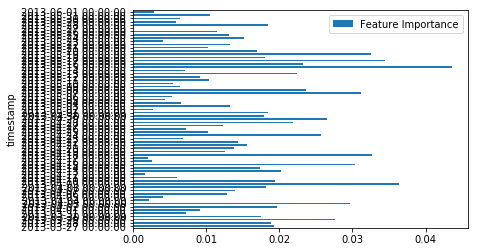

In [120]:
feat_importance = grid_clf.best_estimator_.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=audio_time_df.columns[:-1]).plot(kind='barh')

⬆️Need to design feature

## Naive bayes

In [146]:
# train the model
gnb_model = sknb.GaussianNB()
# given time series, predict cluster
gnb_model.fit(X_train,y_train)
# test the model
y_pred = gnb_model.predict(X_test)
gnb_model.score(X_test,y_test)

0.375

Try use PCA 

In [143]:
# train the model
gnb_model = sknb.GaussianNB()
# given sepal length, predict if setosa
gnb_model.fit(reduced_X_train,y_train)
# test the model
y_pred = gnb_model.predict(reduced_X_test)
gnb_model.score(reduced_X_test,y_test)

0.125

Adjust the data into standard scale

In [117]:
scaler = StandardScaler()
train_x_scale = scaler.fit_transform(X_train_imp)
test_x_scale =  scaler.fit_transform(X_test)
gnb_model_scale = sknb.GaussianNB()
# given sepal length, predict if setosa
gnb_model_scale.fit(train_x_scale,y_train)
# test the model
y_pred = gnb_model_scale.predict(test_x_scale)
gnb_model_scale.score(test_x_scale,y_test)

0.25

Try combined data with original nb

In [248]:
# train the model
gnb_model = sknb.GaussianNB()
# given time series, predict cluster
gnb_model.fit(X_train_combine,y_train_combine)
# test the model
y_pred = gnb_model.predict(X_test_combine)
gnb_model.score(X_test_combine,y_test_combine)

0.625

Cross validation shows that the score varies largely,

In [17]:
!conda list scikit-learn

# packages in environment at /anaconda3:
#
scikit-learn              0.20.1           py36h4f467ca_0  


In [429]:

gnb_model_1 = MultinomialNB(alpha=2)# GaussianNB(var_smoothing=0)
np.mean(cross_vali(gnb_model_1,X_au_feature_whole,y_au_feature_whole))

----- 3 0.45054945054945056
----- 4 0.4513888888888889
----- 5 0.4523809523809524
----- 7 0.4510204081632653
----- 10 0.4533333333333333


0.4517346066631781

In [433]:

gnb_model_1 = MultinomialNB(alpha=2)# GaussianNB(var_smoothing=0)
np.mean(cross_vali(gnb_model_1,X_st_feature_whole,y_st_feature_whole))

----- 3 0.38095238095238093
----- 4 0.4166666666666667
----- 5 0.41428571428571426
----- 7 0.4316326530612245
----- 10 0.3883333333333333


0.40637414965986396

In [428]:
gnb_model_1 = MultinomialNB(alpha=2)# GaussianNB(var_smoothing=0)
np.mean(cross_vali(gnb_model_1,X_ld_feature_whole,y_ld_feature_whole))

----- 3 0.44871794871794873
----- 4 0.3930555555555555
----- 5 0.3841269841269841
----- 7 0.4261904761904762
----- 10 0.4383333333333333


0.4180848595848595

In [431]:
gnb_model_2 = MultinomialNB(alpha=2)
np.mean(cross_vali(gnb_model_2,X_ld_au_feature_whole,y_ld_au_feature_whole))

----- 3 0.4230769230769231
----- 4 0.3930555555555555
----- 5 0.3841269841269841
----- 7 0.4057823129251701
----- 10 0.4383333333333333


0.40887502180359325

In [73]:
# Cross Validation
def cross_val(X, y, k=5):
    # X: data frame
    # y: Series
    # k: num of folds
    num_student = X.shape[0]
    split_size = np.floor(num_student/k)
    acc = []
    cuts = []
    for i in range(num_student):

        if i%split_size == 0:
            cuts.append(i)
            
    cuts.append(num_student)
    print (cuts)
    # shuffle rows
    X = X.sample(frac=1,random_state=2018)
    y = y.sample(frac=1,random_state=2018)
    
    
    # make splits
    splits_x = {} # 0: data, 1: data
    splits_y = {}
    for i in range(k):
        splits_x[i] = X.iloc[cuts[i]:cuts[i+1],:]
        splits_y[i] = y.iloc[cuts[i]:cuts[i+1]]
        
        
        
    # cross validate
    for i, test_x in splits_x.items():

        train_j = [j_k for j_k,_ in splits_x.items() if j_k != i] 

        train_x = pd.DataFrame()
        train_y = pd.Series()
        for j in train_j:
            train_x=train_x.append(splits_x[j])#,ignore_index=True)
            train_y=train_y.append(splits_y[j])#,ignore_index=True)

        test_y = splits_y[i]

        # NB code
        
        # train the model
        gnb_model = sknb.GaussianNB()

        # given time series, predict cluster
        gnb_model.fit(train_x,train_y)
        
        # test the model
        y_pred = gnb_model.predict(test_x)
        print('real: ',test_y.values)
        print('pred: ',y_pred)
        print("Number of correctly labeled points out of a total %d points : %d" % (test_x.shape[0],(test_y == y_pred).sum()))
        acc.append ((test_y == y_pred).sum()/test_x.shape[0])

    print ('Cross Validation Accuracy for {} folds: {}'.format(k,acc))
    print('Accuracy:', np.average(acc))
    return splits_x,splits_y # can be other things you want

In [79]:
cross_val(X_ld_whole, y_ld_whole, k=8)

[0, 5, 10, 15, 20, 25, 30, 35, 40]
real:  [0. 3. 3. 1. 4.]
pred:  [0. 1. 0. 1. 1.]
Number of correctly labeled points out of a total 5 points : 2
real:  [1. 1. 0. 0. 3.]
pred:  [0. 1. 4. 0. 0.]
Number of correctly labeled points out of a total 5 points : 2
real:  [1. 1. 4. 3. 4.]
pred:  [4. 0. 0. 4. 4.]
Number of correctly labeled points out of a total 5 points : 1
real:  [3. 2. 3. 4. 0.]
pred:  [4. 0. 0. 0. 0.]
Number of correctly labeled points out of a total 5 points : 1
real:  [4. 4. 2. 4. 0.]
pred:  [0. 4. 0. 4. 1.]
Number of correctly labeled points out of a total 5 points : 2
real:  [0. 4. 4. 2. 0.]
pred:  [3. 4. 0. 0. 1.]
Number of correctly labeled points out of a total 5 points : 1
real:  [2. 4. 1. 0. 4.]
pred:  [3. 1. 1. 0. 0.]
Number of correctly labeled points out of a total 5 points : 2
real:  [1. 1. 1. 0. 0.]
pred:  [3. 0. 0. 0. 4.]
Number of correctly labeled points out of a total 5 points : 1
Cross Validation Accuracy for 8 folds: [0.4, 0.4, 0.2, 0.2, 0.4, 0.2, 0.4, 0.

({0:                    2013-03-27  2013-03-28  2013-03-29  2013-03-30  2013-03-31  \
  deseasoned_hr_u23    0.059106   -2.059846   -1.369271   -1.354236   -1.050313   
  deseasoned_hr_u54    6.594325   -0.277049    0.406991   -1.715926   -0.139954   
  deseasoned_hr_u03  -12.986627   -0.550278   -1.236319   -9.256204   -3.145595   
  deseasoned_hr_u43   -0.154711   -0.154711   -0.154711   -0.154711   -0.154711   
  deseasoned_hr_u56   -1.421204    0.099401    6.089877  -11.436071   -7.940754   
  
                     2013-04-01  2013-04-02  2013-04-03  2013-04-05  2013-04-06  \
  deseasoned_hr_u23   -0.128889    1.268438    2.874757   -3.842049    1.027708   
  deseasoned_hr_u54    3.524444   -1.226667   -1.869563   -0.747176   -2.457870   
  deseasoned_hr_u03   -5.585278   -0.126646   -1.386905   -2.380486   -0.126646   
  deseasoned_hr_u43    5.909861    0.537438    2.856875   -0.415198   -9.078704   
  deseasoned_hr_u56    9.162917    1.046563    1.178519    2.967099    0.555595  

In [69]:
gnb_model.predict(X_test_combine),y_test_combine

NameError: name 'X_test_combine' is not defined

Search for appropreate prior

In [124]:
# prior = [i/10 for i in range(1,10)]
# for p in prior:
#     gnb_model_scale = sknb.GaussianNB(priors = [p,1-p])
#     train_p = scaler.fit_transform(X_train_imp) # ,'SOURCE_APP_BYTES','REMOTE_APP_PACKETS'
#     gnb_model_scale.fit(train_p,y_train)
#     # test the mode
#     test_p = scaler.fit_transform(X_test)
#     y_pred = gnb_model_scale.predict(test_p)
#     print('prior:',[p,round(1-p,1)],'accuracy:',gnb_model_scale.score(test_p,test_y))